In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import sys
sys.path.append("../../pnria/pot/POT")
import ot
import ot.plot

import math
from tqdm.notebook import tqdm

from tempfile import TemporaryDirectory

import imageio
import scipy.sparse as sparse
import pickle

plt.rcParams['axes.facecolor'] = 'white'

In [26]:
n_points = 40000
size = (720, 720)

In [3]:
def convert_to_black_probabilities(im):
    flattened_array = im.reshape(-1) # 0 is black, 255 is white
    blackness = 255 - flattened_array # 0 is white, 255 is black
    return blackness / sum(blackness)

In [4]:
def convert_pic_to_scatter_plot(black_probabilities, initial_shape, n_points=10000):
    points = np.random.choice(black_probabilities.shape[0], replace=True, size=(n_points, ), p=black_probabilities)
    p1, p2 = np.unravel_index(points, initial_shape)
    rand = np.random.random((2, n_points))
    return p1 + rand[0], p2 + rand[1]

In [49]:
def display_scatter(source, show=True, size=None):
    x, y = source[..., 0], source[..., 1]
    size = size or (y.max() - y.min(), x.max() - x.min())
    n_points = x.shape[0]
    plt.scatter(y, -x, s=2000. / n_points, c='k', marker=".")
    plt.xlim(0, size[0] + 1)
    plt.ylim(-size[1], 0)
    plt.axis('off')
    if show:
        plt.show()

In [6]:
def im2dots(pil_image, n_points, size):
    if size is not None:
        pil_image = pil_image.resize(size)
    pil_image = pil_image.convert(mode="L")
    im = np.array(pil_image)
    im[im == 0.] = 255
    probabilities = convert_to_black_probabilities(im)
    x, y = convert_pic_to_scatter_plot(probabilities, im.shape, n_points)
    return np.stack([x, y], axis=-1)

In [29]:
image_source = Image.open("Monge.jpg")
image_target = Image.open("Kantorovich.jpg")

In [30]:
xs = im2dots(image_source, n_points, size)
xt = im2dots(image_target, n_points, size)

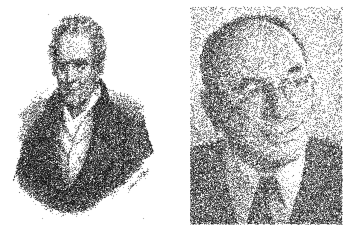

In [62]:
plt.subplot(1, 2, 1)
display_scatter(xs, show=False, size=size)
plt.subplot(1, 2, 2)
display_scatter(xt, show=False, size=size)
plt.show()

In [32]:
def compute_transport_plan(xs, xt):
    n_points = xs.shape[0]
    a = np.ones((n_points,)) / n_points # uniform distribution on samples
    b = np.ones((n_points,)) / n_points
    M = ot.dist(xs, xt)
    G, log = ot.emd(a, b, M, numThreads=24, numItermax=5_000_000_000, log=True)
    print(log)
    return sparse.csr_matrix(G) * n_points, log

In [33]:
G, log = compute_transport_plan(xs, xt)

{'cost': 9677.660005234264, 'u': array([ 25390.72161782,  10983.43235932, -26965.59781956, ...,
       -19127.91210464, -33024.87200385,  18055.58547512]), 'v': array([-2533.09314152,   465.90071254, 50671.20192323, ...,
       19816.64829425, 19680.10324025,  1812.14468874]), 'warning': None, 'result_code': 1}


In [34]:
G

<40000x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 40000 stored elements in Compressed Sparse Row format>

In [35]:
def get_points_at_t(xs, xt, G, t):
    # barycenter between xs and its corresponding xt
    # linear translation: at xs for t=0 and at xt for t=1
    return (1 - t) * xs + t * G @ xt

In [40]:
def make_time_dimension(n_frames):
    if n_frames % 2 == 0:
        print("Adding a frame for symmetry purposes")
        n_frames += 1
    x = np.linspace(0, 1, math.ceil(n_frames / 2))
    t = np.concatenate([
            x[:-1], np.flip(x)
        ],
        axis=0
    )
    return t

In [60]:
def make_gif(xs, xt, G, n_frames, gif_name="mygif"):
    with TemporaryDirectory() as tmpdirname:
        
        time_dim = make_time_dimension(n_frames)
        n = len(time_dim)
        fig = plt.figure(figsize=(6.4, 9.6))
        
        def make_frame(index, xs, xt, G):
            t = time_dim[index]
            points = get_points_at_t(xs, xt, G, t)
            display_scatter(points, show=False, size=size)
            plt.savefig(f"{tmpdirname}/{index}.png", transparent=False, bbox_inches='tight')
            plt.clf()

        for index in tqdm(range(n), desc="Making pictures"):
            make_frame(index, xs, xt, G)

        plt.close()
        plt.cla()
        plt.clf()
        
        with imageio.get_writer(f"{gif_name}.gif", mode="I", fps=60) as writer:
            for i in tqdm(range(n), desc="Merging pictures"):
                filename = f"{tmpdirname}/{i}.png"
                image = imageio.imread(filename)
                writer.append_data(image)
            print("The merger is complete")


In [61]:
make_gif(xs, xt, G, 240)

Adding a frame for symmetry purposes


Merging pictures:   0%|          | 0/241 [00:00<?, ?it/s]

The merger is complete
